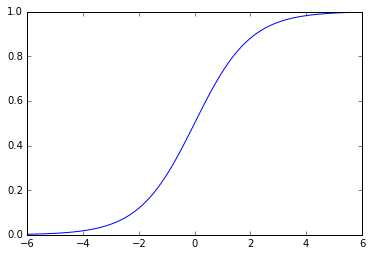

In [4]:
import numpy as np
from matplotlib import pyplot

%matplotlib inline

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(z):
  """Sigmod derivative."""
  return np.multiply(sigmoid(z), (1 - sigmoid(z)))

def plot_func(func, x):
  pyplot.plot(x, func(x))

def plot_sigmoid():
  plot_func(sigmoid, np.arange(-6, 6, 0.1))  
  
plot_sigmoid()

In [5]:
def get_weight_sizes(unit_sizes):
  """Returns sizes for each weight matrix according to all units."""
  layer_sizes = []
  prev_unit_size = unit_sizes[0]
  for unit_size in unit_sizes[1:]:    
    layer_sizes.append([unit_size, prev_unit_size + 1])
    prev_unit_size = unit_size
  return layer_sizes

def generate_weights(input_size, output_size, hidden_layer_size, num_hidden_layers=1):  
  """Returns array of matrices representing weights (connections between units)."""
  unit_sizes = [input_size] + num_hidden_layers * [hidden_layer_size] + [output_size]
  print "Unit sizes", unit_sizes
  weight_sizes = get_weight_sizes(unit_sizes)
  print "Weight sizes", weight_sizes
  return [2 * np.random.random(weight_size) - 1 for weight_size in weight_sizes]
 
def unroll_weights(weights):
  """Turn list of matrices to a list of all the elements in order."""
  unrolled = []
  for weight in weights:
    unrolled += np.asarray(weight).flatten().tolist()  
  return np.matrix(unrolled)

def expand_weights(theta, weight_sizes):  
  offset = 0
  weights=[]
  for rows, cols in weight_sizes:    
    length = rows * cols
    chunk = np.squeeze(np.asarray(theta)).tolist()[offset:offset+length]        
    weights.append(np.array(np.reshape(chunk, (rows, cols))))    
    offset += length
  return weights

In [19]:
# Loading image
from io import BytesIO
from matplotlib import pyplot

%matplotlib inline

from PIL import Image
import os

training_data_dir = os.path.join(os.getcwd(), "handwriting", "training-data")

def image_to_intensity(im):
  im.convert('LA')
  return [1 - np.average(color)/255 for color in list(im.getdata())]

def get_handwriting_training_files(letter):
  directory = os.path.join(training_data_dir, letter)  
  for (dirpath, dirnames, filenames) in os.walk(directory):
    for filename in filenames:
      yield os.path.join(directory, filename)

def get_handwriting_training_data(letter, start=0, limit=1000000, display=0, w=20, h=20):
  i = -1
  for filename in get_handwriting_training_files(letter):
    i += 1
    if i < start:
      continue      
    if i > limit:
      break
    im = Image.open(filename)
    im.thumbnail((w, h), Image.ANTIALIAS)
      
    if i < display:
      pyplot.figure()
      pyplot.imshow(np.asarray(im))
            
    data = image_to_intensity(im)
    if len(data) != w*h:
        print "Bad size for image", letter, i        
    yield data

In [20]:
# y - all the input examples without the x0 = 1 column
# y - all the ouputs of the neural net
# weights - a list of matrices for each layer of neural network
def cost_function(x, y, weights, g=sigmoid, dg=dsigmoid, lamb=0.0):
  m = x.shape[0]
  j = 0;
  grad = 0;

  one_column = np.ones([m, 1])  
  num_hidden_layers = len(weights) - 1
  
  # input layer + hidden layers + output layer
  num_layers = num_hidden_layers + 2
    
  # number of rows in the last weight matrix is the number of output classes.
  num_classes = weights[-1:][0].shape[0]
  
  # print "Number of layers:", num_layers
  # print "Number of hidden layers:", num_hidden_layers
  # print "Number of classes", num_classes
 
  # Map the output to a class vector for the last layer : e.g. 3 --> [0, 0, 1, 0, ...]
  y_ = np.zeros((m, num_classes))  
  for i in range(0, m):
    y_[i, y[i]] = 1

  #######################
  # Forward propagation #
  #######################
  a = [None] * num_layers
  z = [None] * num_layers

  a[0] = np.c_[one_column, x]
  # print "Propagating from layer %d to %d" % (1, 2)
    
  for i in range(1, num_layers):
    # print "Propagating from layer %d to %d" % (i+1, i+2)
    z[i] = np.dot(a[i-1], weights[i-1].T)
    a[i] = np.c_[one_column, g(z[i])]
  
  # Remove the one column. This is the hypothesis applied to all data.
  h = a[num_layers-1][:, 1:]
        
  ##################
  # Regularization #
  ##################
  reg_inner_term = 0.0
  if lamb > 0.0:
    for theta in weights:
      # We skip the first column (or we could dub it zero.)
      reg_inner_term += np.sum(theta[:, 1:] ** 2)    
    reg_inner_term *= 0.5 * lamb

  ########
  # Cost #
  ########
  cost_0_term = np.multiply(-y_, np.log(h)) # element-wise multiplication
  cost_1_term = np.multiply((1 - y_), np.log(1 - h)) # element-wise multiplication
  cost = (np.sum(cost_0_term + cost_1_term) + reg_inner_term) / m;
  
  ##############################
  # Backpropagation & Gradient #
  ##############################
  delta = [None] * num_layers  
  weights_grad = [0.0] * (num_hidden_layers + 1)
  
  for t in range(0, m):
    delta[num_layers - 1] = (h[t] - y_[t]).T
    # Use one column when multiplying, afterwards remove the one-row.
    for j in range(num_layers-1, 1, -1):
      delta[j - 1] = np.multiply(weights[j - 1].T * delta[j], dg(np.c_[1, z[j - 1][t]].T))[1:, :]
    
    for j in range(0, num_hidden_layers+1):
      weights_grad[j] += delta[j + 1] * a[j][t]
  
  for j in range(0, num_hidden_layers + 1):
    # Should be vector.
    grad_reg_term = 0
    if lamb > 0.0:
      grad_reg_term = lamb * weights[j]    
      grad_reg_term[0] = 0    
    weights_grad[j] = (weights_grad[j] + grad_reg_term) / m
    
  grad = np.matrix(unroll_weights(weights_grad))
  
  return (cost, grad)


In [21]:
# alpha = learning rate
# dg - gradient of cost_function
def gradient_descent(theta, dg, alpha=0.1, precision=0.0001, iterations=1000):
  last_cost = 100000
  for i in range(0, iterations):
    theta -= alpha * dg    
    weights=expand_weights(theta, weight_sizes)
    cost, dg = cost_function(x,y, weights)          
    limit_reached = (abs(cost) < precision) or (cost > last_cost)
    if i % 20 == 0 or limit_reached:
      print "Cost", cost, "Precision:", precision
    
    if limit_reached:
      break
        
    last_cost = cost
    
    
  return weights

Unit sizes [900, 60, 60, 10]
Weight sizes [[60, 901], [60, 61], [10, 61]]
training_set_size: 100
Loading letters: a c g k Bad size for image k 77
o p Bad size for image p 80
r t x Bad size for image x 74
Bad size for image x 75
Bad size for image x 76
Bad size for image x 77
Bad size for image x 78
Bad size for image x 79
Bad size for image x 80
Bad size for image x 81
Bad size for image x 82
Bad size for image x 83
Bad size for image x 84
Bad size for image x 85
Bad size for image x 86
Bad size for image x 87
Bad size for image x 88
Bad size for image x 89
Bad size for image x 90
Bad size for image x 91
Bad size for image x 92
Bad size for image x 93
Bad size for image x 94
Bad size for image x 95
Bad size for image x 96
Bad size for image x 97
Bad size for image x 98
Bad size for image x 99
_
Input and output sizes ((1L, 930L), (930L, 1L))


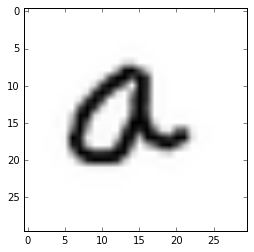

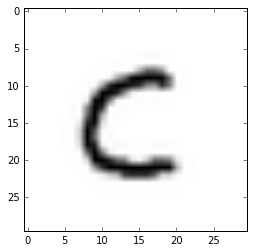

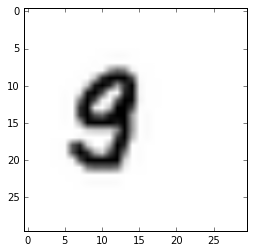

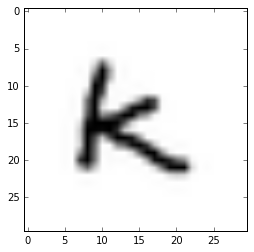

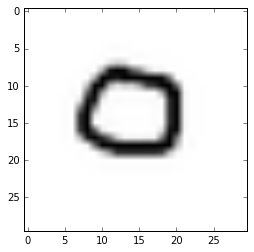

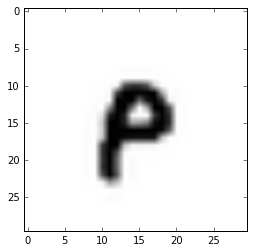

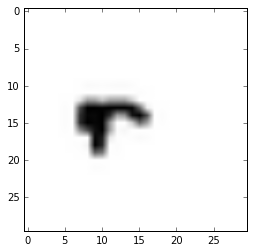

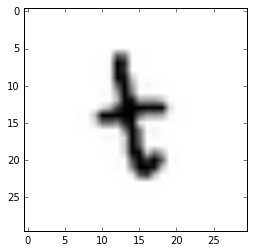

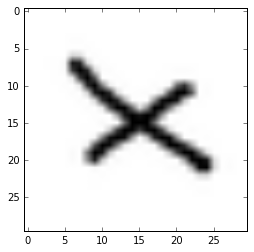

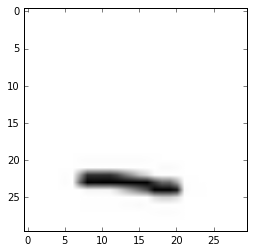

In [27]:
# all available letter training data
letters="kopar_tgcx"

i=0
training_data = {}
for l in letters:  
  training_data[l]=i
  i+=1

training_data_reverse = {v: k for k, v in training_data.items()}

img_width = 30
img_height = 30

# Neural network specification
input_size = img_width * img_height
output_size = len(training_data.values())
hidden_layer_size = 60
num_hidden_layers = 2

# Random initial weights for the NN.
weights = generate_weights(input_size, output_size, hidden_layer_size, num_hidden_layers)

# for debug only
unit_sizes = [input_size] + num_hidden_layers * [hidden_layer_size] + [output_size]  
weight_sizes = get_weight_sizes(unit_sizes)

input_data = []
output_data = []

# Percentage of the data set used for training (the rest goes for testing/cross-validation)
training_percentage = 1.0 # 0.7

example_set_size = 100
training_set_size = int(round(example_set_size * training_percentage))

print "training_set_size:", training_set_size

print "Loading letters:",

for letter, y_val in training_data.iteritems():
  print letter,
  i = 0  
  
  for sample in get_handwriting_training_data(letter, display=1, start=0, limit=training_set_size,w=img_width, h=img_height):
    if i < training_set_size:      
      input_data.append(sample)
      output_data.append(y_val)
    i += 1
  
x = np.matrix(input_data)
y = np.matrix(np.array(output_data)).T

print
print "Input and output sizes", (x.shape, y.shape)



In [24]:
cost, grad = cost_function(x, y, weights)
print cost, grad.shape

-10.1113904344 (1L, 58330L)


In [25]:
# Train the neural network (find optimal weights for the training set)
opt_weights = gradient_descent(theta=unroll_weights(weights), alpha=0.3, precision=0.01, dg=grad)
opt_weights

Cost 2.19530342644 Precision: 0.01
Cost 0.990467164478 Precision: 0.01
Cost 0.73400059948 Precision: 0.01
Cost 0.578903521438 Precision: 0.01
Cost 0.477625665578 Precision: 0.01
Cost 0.407199627142 Precision: 0.01
Cost 0.354992392802 Precision: 0.01
Cost 0.313972913541 Precision: 0.01
Cost 0.280309448885 Precision: 0.01
Cost 0.2518721078 Precision: 0.01
Cost 0.227413229741 Precision: 0.01
Cost 0.206146740945 Precision: 0.01
Cost 0.187514689933 Precision: 0.01
Cost 0.171065413319 Precision: 0.01
Cost 0.156417395336 Precision: 0.01
Cost 0.143261022023 Precision: 0.01
Cost 0.131356878629 Precision: 0.01
Cost 0.120522415219 Precision: 0.01
Cost 0.110615965447 Precision: 0.01
Cost 0.1015246347 Precision: 0.01
Cost 0.0931566575905 Precision: 0.01
Cost 0.0854366004293 Precision: 0.01
Cost 0.0783020641815 Precision: 0.01
Cost 0.071701270532 Precision: 0.01
Cost 0.0655912926932 Precision: 0.01
Cost 0.0599367268799 Precision: 0.01
Cost 0.0547085074934 Precision: 0.01
Cost 0.0498825425332 Precisi

[array([[-0.62649354, -0.31831038, -0.75971881, ...,  0.39364438,
          0.74575938, -0.05256958],
        [ 0.31452221,  0.67248557,  0.26435874, ...,  0.19110036,
          0.75334105, -0.65432596],
        [ 0.40913914,  0.39003658,  0.89791723, ..., -0.78429581,
          0.94650086,  0.00413952],
        ..., 
        [ 1.02902725, -0.72875348,  0.3230101 , ...,  0.14110877,
          0.82549563,  0.39306593],
        [-0.74451739,  0.53050645, -0.12608773, ..., -0.41664837,
         -0.03019848,  0.06225509],
        [ 0.15100908, -0.41063525, -0.17847507, ..., -0.91709398,
         -0.18426867, -0.17784615]]),
 array([[ 0.90062018, -0.15141775,  0.12783655, ..., -0.17765284,
         -0.62033524, -0.4444111 ],
        [-0.74727796, -0.41308084, -0.36441167, ..., -0.8380564 ,
          0.75092147,  0.23036846],
        [-0.06370289, -0.1709551 ,  0.32136091, ...,  0.0645324 ,
         -0.48101805,  0.74604787],
        ..., 
        [-0.50567894,  0.1185775 , -0.7308571 , ...,

In [26]:
def predict(x, weights):
  m = len(x)  
  prev_layer = sigmoid( np.matrix([1] + x) * weights[0].T);
  for j in range(1, len(weights)):    
    current_layer = sigmoid(np.matrix([1] + np.squeeze(np.asarray(prev_layer)).tolist()) * weights[j].T);
    prev_layer = current_layer
  return np.argmax(np.asarray(current_layer))

errors = 0
tests = 0
for letter, _ in training_data.iteritems():  
  for sample in get_handwriting_training_data(letter, start=training_set_size, w=img_width, h=img_height):
    prediction = predict(sample, opt_weights)
    predicted_letter = training_data_reverse[ prediction ]
    tests += 1
    valid = True
    if letter is not predicted_letter:
      errors += 1
      valid = False
    print "Prediction for input ", letter, " is ", predicted_letter, "" if valid else "error!"

print "accuracy %.4f%%" % ((tests - errors) * 100.0 / tests)
      


Prediction for input  a  is  a 
Prediction for input  a  is  k error!
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  x error!
Prediction for input  a  is  a 
Prediction for input  a  is  x error!
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  k error!
Prediction for input  a  is  o error!
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  o error!
Prediction for input  a  is  a 
Prediction for input  a  is  t error!
Prediction for input  a  is  a 
Prediction for input  a  is  o error!
Prediction for input  a  is  a 
Prediction for input  a  is  a 
Prediction for input  a  is  o error!
Prediction for input  a  is  g error!
Prediction for input  a  is  o error!
Prediction for input  a  is  x error!
Prediction for input  a  is  a 


ValueError: shapes (1,871) and (901,60) not aligned: 871 (dim 1) != 901 (dim 0)